In [31]:
import pandas as pd
import win32com.client as win32
import matplotlib.pyplot as plt

In [32]:
url="https://portafolioinfdoctos.cnbv.gob.mx/Documentacion/minfo/XLS/40/040_13b_R1.xls"

In [33]:
#Declarar el objeto de Excel utilizando makepy para generar las clases de Excel
excel = win32.gencache.EnsureDispatch('Excel.Application')
wb = excel.Workbooks.Open(url)

In [34]:
#Imprimir el nombre de las hojas del libro de excel
for sheet in wb.Worksheets:
    print(sheet.Name)

MINFO
Notas
BD
Formato
Query
Notas T
Calidad de Información


In [35]:
#Eliminar filtro de la tabla dinámica de la hoja "BD" 
pvtTable = wb.Sheets("BD").Range("G6").PivotTable

In [36]:
page_range_item = []
for i in pvtTable.PageRange:
    page_range_item.append(str(i))
    
print(page_range_item)

['cve_destino_credito_grupo', '8.0', 'cve_institucion', '040138', 'cve_periodo', '202112.0']


In [37]:
#Limpiar filtros de la tabla dinámica

filtros=["cve_periodo","cve_institucion","cve_destino_credito_grupo"]

#cve_destino_credito_grupo a excluir
bye = ["8","9"]

for variables in filtros:
    pvtTable.PivotFields(variables).ClearAllFilters()
#Filtrar cve_destino_credito_grupo
for elementos in bye:
    pvtTable.PivotFields("cve_destino_credito_grupo").PivotItems(elementos).Visible = False

#Establecemos cve_periodo como columna
pvtTable.PivotFields("cve_periodo").Orientation = 1
#Eliminar la variable id de la tabla dinámica
pvtTable.PivotFields("id").Orientation = 0

In [38]:
#Traer los datos de la tabla dinámica a un dataframe
df = pd.DataFrame(pvtTable.TableRange1.Value)
#Fila 1 del dataframe como encabezado
df.columns = df.iloc[1]
#liminar filas innecesarías
df = df.drop([0,1])
#Eliminar última fila
df = df.drop(df.index[-1])
#Convertir cve_periodo a string
df["cve_periodo"] = df["cve_periodo"].astype(str)
#Crear variables de año y mes
df["año"] = df["cve_periodo"].str[0:4]
df["mes"] = df["cve_periodo"].str[4:6]
#Crear variable de fecha y pasarla a datetime
df["fecha"] = df["año"] + "-" + df["mes"] + "-01"
df["fecha"] = pd.to_datetime(df["fecha"])
#Eliminar variables de año y mes
df = df.drop(["cve_periodo"], axis=1)
#Agregar media móvil de 3 meses
#Ordenar por fecha
df = df.sort_values(by="fecha")
df["media_movil"] = df["Suma de creditos"].rolling(3).mean()
#Renombrar columnas
df = df.rename(columns={"Suma de creditos":"creditos","Suma de monto":"monto"})
df

1,creditos,monto,año,mes,fecha,media_movil
151,5905.0,4318391637.0,2009,07,2009-07-01,NaN
150,5382.0,4044623811.0,2009,08,2009-08-01,NaN
149,5486.0,4153916341.0,2009,09,2009-09-01,5591.000000
148,5135.0,3903630326.0,2009,10,2009-10-01,5334.333333
147,4929.0,3656391473.0,2009,11,2009-11-01,5183.333333
...,...,...,...,...,...,...
6,32438.0,24786322295.0,2021,08,2021-08-01,29732.333333
5,29515.0,24420925321.0,2021,09,2021-09-01,30427.666667
4,27984.0,22820959830.0,2021,10,2021-10-01,29979.000000
3,25132.0,22247216194.0,2021,11,2021-11-01,27543.666667


In [39]:
#Cerrar el libro de excel sin guardar los cambios
wb.Close(False)

Text(0.2, -0.14, 'Fuente: @claudiodanielpc con información de CNBV')

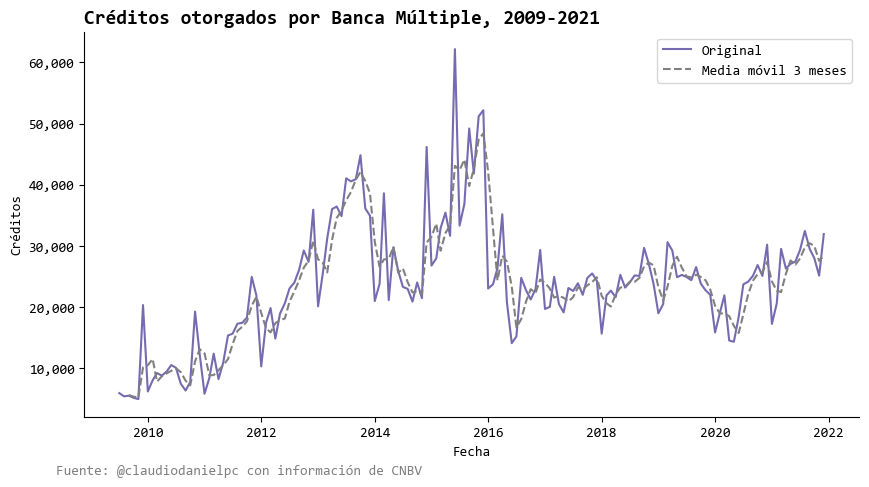

In [40]:
plt.rcParams["font.family"]="Consolas"
c="#756bb1"

#Gráfica de línea de la variable "Suma de creditos" y su media móvil de 12 meses
fig = plt.subplots(figsize=(10,5))
plt.plot(df["fecha"], df["creditos"], color=c, label="Original")
plt.plot(df["fecha"], df["media_movil"], color="grey", label="Media móvil 3 meses", linestyle="--")

#Agregar título a la gráfica
plt.title("Créditos otorgados por Banca Múltiple, 2009-2021", fontsize=14, fontweight="bold", loc="left")
#Agregar etiqueta al eje x
plt.xlabel("Fecha")
#Agregar etiqueta al eje y
plt.ylabel("Créditos")
#Eje y con comas
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
#ELiminar marco superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#Agregar leyenda
plt.legend()
plt.text(0.2, -0.14, 'Fuente: @claudiodanielpc con información de CNBV', fontsize=10, color='gray', ha='center', va='center', transform=plt.gca().transAxes)